In [431]:
!echo $HOSTNAME

n-62-20-9


In [432]:
import numpy as np
import math
import scipy as sp
from scipy import interpolate
from numpy.linalg import solve
import matplotlib.pyplot as plt
from skimage.measure import profile_line
from time import time

In [433]:
from cil.optimisation.algorithms import GD, FISTA, PDHG
from cil.optimisation.operators import BlockOperator, GradientOperator,\
                                       GradientOperator
from cil.optimisation.functions import IndicatorBox, MixedL21Norm, L2NormSquared, \
                                       BlockFunction, L1Norm, LeastSquares, \
                                       OperatorCompositionFunction, TotalVariation, \
                                       ZeroFunction

In [434]:
from cil.io import NikonDataReader
from cil.utilities.jupyter import islicer
from cil.utilities.display import show_geometry, show2D
from cil.recon import FDK
from cil.plugins.tigre import FBP, ProjectionOperator
from cil.processors import TransmissionAbsorptionConverter, Slicer
from cil.optimisation.algorithms import CGLS, SIRT

In [435]:
from cil.framework import ImageData, ImageGeometry, AcquisitionData, AcquisitionGeometry

In [436]:
def calc_intersection_length(ray_direction, rho, im_width, im_pixel, coordinate_shift):
    # assume theta in [0,Pi]
    # checks if \ell_{\theta,\rho} intersects im_pixel (row-major) in im
    # convert im_pixel to 2D index
    i,j = divmod(im_pixel, im_width)
    # coordinates of the edges of pixel
    x_left = i + coordinate_shift - 0.5
    x_right = x_left + 1
    y_bottom = j + coordinate_shift - 0.5
    y_top = y_bottom + 1
    
    # ray_intersects_pixel = 0
    # ray_x > 1 corresponds to theta < pi/2
    if ray_direction[0] > 0:
        rho_top_right = x_right * ray_direction[0] + y_top * ray_direction[1]
        rho_bottom_left = x_left * ray_direction[0] + y_bottom * ray_direction[1]
        if (rho_top_right < rho) or (rho < rho_bottom_left):
            return None
    else:
        rho_top_left = x_left * ray_direction[0] + y_top * ray_direction[1]
        rho_bottom_right = x_right * ray_direction[0] + y_bottom * ray_direction[1]
        if (rho_top_left < rho) or (rho < rho_bottom_right):
            return None
    

    if np.sum(np.isclose(ray_direction,0)) > 0:
        return 1
    
    x_crossings = np.zeros(2)
    y_crossings = np.zeros(2)
    y_left = (rho - x_left*ray_direction[0]) / ray_direction[1]
    y_right = (rho - x_right*ray_direction[0]) / ray_direction[1]
    if y_left > y_top:
        y_crossings[0] = y_top
        x_crossings[0] = (rho - y_top*ray_direction[1]) / ray_direction[0]
    elif y_left < y_bottom:
        y_crossings[0] = y_bottom
        x_crossings[0] = (rho - y_bottom*ray_direction[1]) / ray_direction[0]
    else:
        y_crossings[0] = y_left
        x_crossings[0] = x_left

    if y_right > y_top:
        y_crossings[1] = y_top
        x_crossings[1] = (rho - y_top*ray_direction[1]) / ray_direction[0]
    elif y_right < y_bottom:
        y_crossings[1] = y_bottom
        x_crossings[1] = (rho - y_bottom*ray_direction[1]) / ray_direction[0]
    else:
        y_crossings[1] = y_right
        x_crossings[1] = x_right
    
    return np.linalg.norm([x_crossings[1]-x_crossings[0], y_crossings[1]-y_crossings[0]])

def construct_A_parallel2D(angles, panel_num_cells, panel_cell_length, im_width):
    # assume square image where pixels are of units 1.0 x 1.0
    # assume rotation axis at the enter of the image
    # x axis vertically down and y axis horizontally right. origin at geometric center of image.
    # lines parametrized by (theta,rho)
    # where theta is rotation angle (angle 0 points in the y-axis direction) and rho is distance from origin

    # from geometrical center of image to center of im[0,0]
    coordinate_shift = -(im_width-1)/2

    # symmetric panel and detector rotation axis is centered at
    panel_pixel_centers = panel_cell_length * ( -(panel_num_cells-1)/2 + np.arange(0, panel_num_cells) )

    num_angles = len(angles)
    im_size = im_width**2
    # A = sp.sparse.csr_matrix((panel_num_cells * num_angles, im_size))
    # A = sp.sparse.lil_matrix((panel_num_cells*num_angles, im_size))
    A = np.zeros((panel_num_cells*num_angles, im_size))
    for proj_idx in range(num_angles):
        theta = np.deg2rad(angles[proj_idx])
        # ray_direction = [-np.sin(angle_rad), np.cos(angle_rad)]
        ray_direction = [np.cos(theta), np.sin(theta)]
        # print(ray_direction)
        idx_shift = proj_idx * panel_num_cells
        for ray_idx in range(panel_num_cells):
            rho = panel_pixel_centers[ray_idx]
            # print(rho)
            for im_pixel in range(im_size):
                intersection_length = calc_intersection_length(ray_direction, rho, im_width, im_pixel, coordinate_shift)
                if intersection_length != None:
                    A[idx_shift + ray_idx, im_pixel] = intersection_length
    
    return A

import concurrent.futures
import itertools

def worker(proj_idx, angles, panel_num_cells, im_width, coordinate_shift, panel_pixel_centers, im_size):
    theta = np.deg2rad(angles[proj_idx])
    ray_direction = [np.cos(theta), np.sin(theta)]
    idx_shift = proj_idx * panel_num_cells
    result = np.zeros((panel_num_cells, im_size))

    for ray_idx in range(panel_num_cells):
        rho = panel_pixel_centers[ray_idx]
        for im_pixel in range(im_size):
            intersection_length = calc_intersection_length(ray_direction, rho, im_width, im_pixel, coordinate_shift)
            if intersection_length is not None:
                result[ray_idx, im_pixel] = intersection_length
    return idx_shift, result

def parallelized_construct_A_parallel2D(angles, panel_num_cells, panel_cell_length, im_width):
    coordinate_shift = -(im_width-1)/2
    panel_pixel_centers = panel_cell_length * ( -(panel_num_cells-1)/2 + np.arange(0, panel_num_cells) )
    num_angles = len(angles)
    im_size = im_width**2
    A = np.zeros((panel_num_cells*num_angles, im_size))

    with concurrent.futures.ProcessPoolExecutor() as executor:
        args = ((proj_idx, angles, panel_num_cells, im_width, coordinate_shift, panel_pixel_centers, im_size) for proj_idx in range(num_angles))
        for idx_shift, result in executor.map(worker, *zip(*args)):
            A[idx_shift:idx_shift + panel_num_cells] = result

    return A

def create_circle_image(image_size, radius, center):
    # Initialize a square image with zeros (black)
    image = np.zeros((image_size, image_size))

    # Create the circle
    for x in range(image_size):
        for y in range(image_size):
            # Check if the pixel is inside the circle
            # x is now the vertical coordinate, and y is the horizontal coordinate
            if (x - center[0]) ** 2 + (y - center[1]) ** 2 < (radius+0.5) ** 2:
                image[x, y] = 1  # Set pixel value to 1 (white) inside the circle
    
    return image

Scans volume is approximately 10 cm in each coordinate direction.

Number of channels: 1
channel_spacing: 1.0
voxel_num : x500,y500
voxel_size : x0.02,y0.02
center : x0,y0

2D Parallel-beam tomography
System configuration:
	Ray direction: [0., 1.]
	Rotation axis position: [0., 0.]
	Detector position: [ 0., 10.]
	Detector direction x: [1., 0.]
Panel configuration:
	Number of pixels: [2000    1]
	Pixel size: [0.005 0.005]
	Pixel origin: bottom-left
Channel configuration:
	Number of channels: 1
Acquisition description:
	Number of positions: 720
	Angles 0-20 in degrees:
[0.  , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 , 2.75,
 3.  , 3.25, 3.5 , 3.75, 4.  , 4.25, 4.5 , 4.75]
Distances in units: units distance


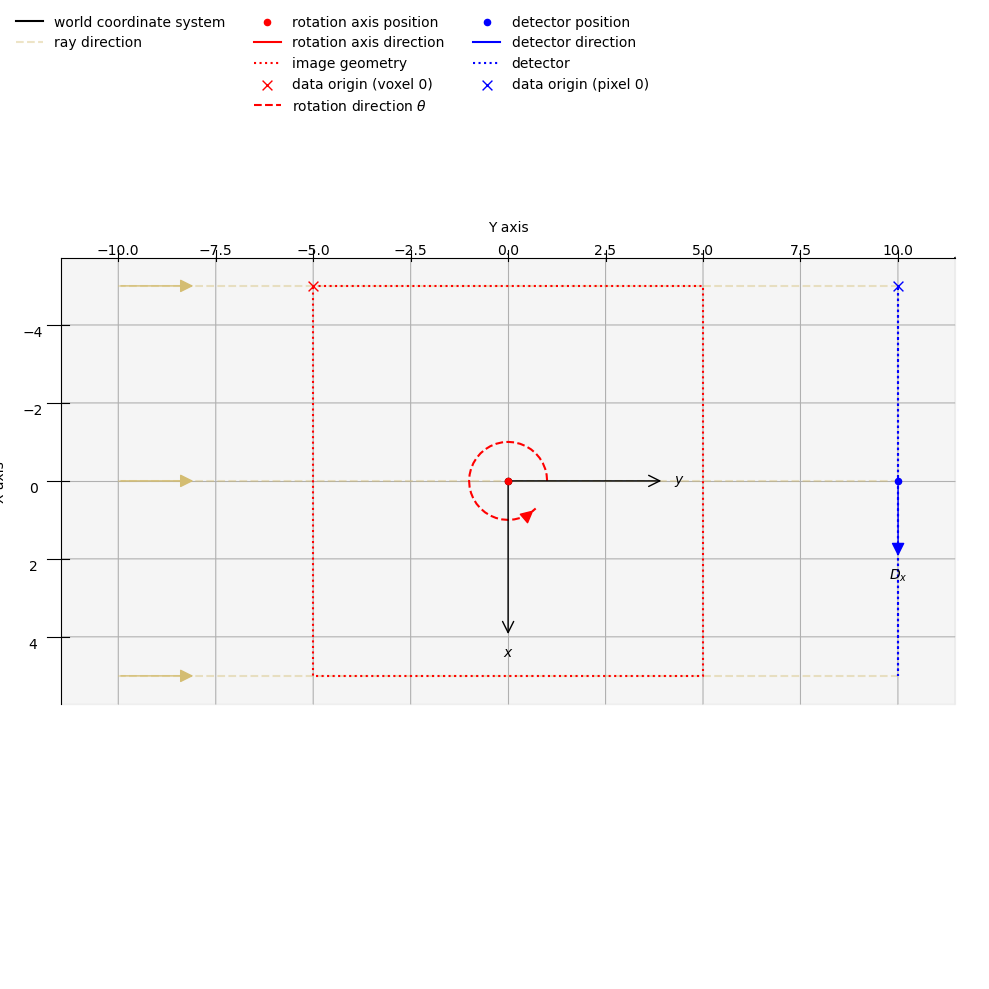

In [437]:
angles = np.linspace(start=0, stop=180, num=4*180//1, endpoint=False)
physical_size = 10 # cm
voxel_num = 500
voxel_size = physical_size/voxel_num

ig = ImageGeometry(voxel_num_x=voxel_num, voxel_num_y=voxel_num, voxel_size_x=voxel_size, voxel_size_y=voxel_size, center_x=0, center_y=0)
print(ig)

factor = 4
panel_num_cells = math.ceil(factor*voxel_num)
panel_cell_length = 1/factor * voxel_size
ag = AcquisitionGeometry.create_Parallel2D(ray_direction=[0,1], detector_position=[0,physical_size], detector_direction_x=[1,0], rotation_axis_position=[0,0])\
    .set_panel(num_pixels=panel_num_cells,pixel_size=panel_cell_length)\
    .set_angles(angles=angles)

print(ag)
show_geometry(ag, ig, grid=True)

float64
float32
Number of dimensions: 2
Shape: (500, 500)
Axis labels: ('horizontal_y', 'horizontal_x')

('horizontal_y', 'horizontal_x')


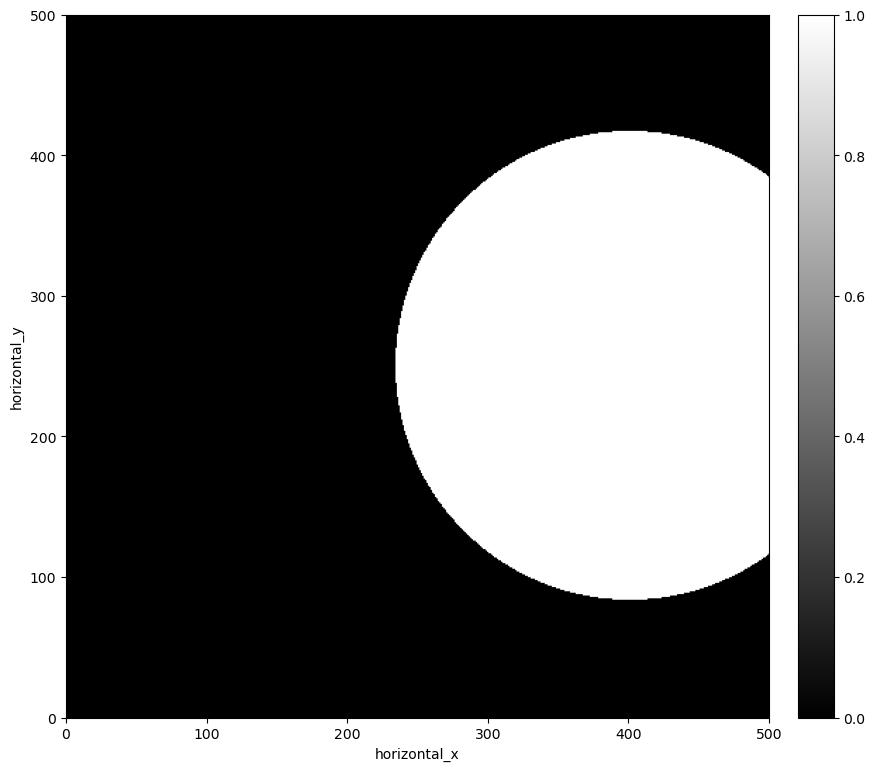

In [463]:
im_arr = create_circle_image(image_size=voxel_num, radius=voxel_num//3, center=[voxel_num//2+150, voxel_num//2])
print(im_arr.dtype)
im_arr = im_arr.astype('float32')
print(im_arr.dtype)

image = ImageData(array=im_arr.T,geometry=ig)
print(image)
print(image.dimension_labels)
show2D(image)
# image.get_data_axes_order(new_order=[1,0])

In [439]:
A = ProjectionOperator(ig, ag, 'Siddon', device='gpu')
# A = ProjectionOperator(ig, ag, 'interpolated', device='gpu')

In [440]:
b = A.direct(image)
print(type(b))
print(b)
b.reorder(order='tigre')
print(b)
print(b.as_array())

<class 'cil.framework.framework.AcquisitionData'>
Number of dimensions: 2
Shape: (720, 2000)
Axis labels: ('angle', 'horizontal')

Number of dimensions: 2
Shape: (720, 2000)
Axis labels: ('angle', 'horizontal')

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [441]:
# t = time()
# # A = construct_A_parallel2D(angles, panel_num_cells, panel_cell_length, im_width)
# A = parallelized_construct_A_parallel2D(angles, voxel_num, 1, voxel_num)
# print(f'construct A: {time()-t}')
# print(f'A.shape: {A.shape}')

In [442]:
# d = A/5 @ im_arr.flatten()
# print(np.sum(d))
# print(np.max(d))
# print(np.max(b))
# np.max(np.abs(b_vec-d))

In [443]:
# show2D(image)

In [444]:
# show2D(b)

In [445]:
# myGD_LS.run(20, verbose=1)

In [446]:
x0 = ig.allocate(0.0)
F = LeastSquares(A, b)
# G = IndicatorBox(lower=0.0)
G = IndicatorBox()
myFISTANN = FISTA(f=F, 
                  g=G, 
                  initial=x0, 
                  max_iteration=1000,
                  update_objective_interval = 30)

In [447]:
myFISTANN.run(200, verbose=1)

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0       1000         0.000          2.22670e+07
       30       1000         0.085          5.05499e+02
       60       1000         0.077          4.57662e+01
       90       1000         0.073          1.03321e+01
      120       1000         0.073          4.35407e+00
      150       1000         0.074          2.10964e+00
      180       1000         0.072          1.14565e+00
-------------------------------------------------------
      200       1000         0.073                     
Stop criterion has been reached.



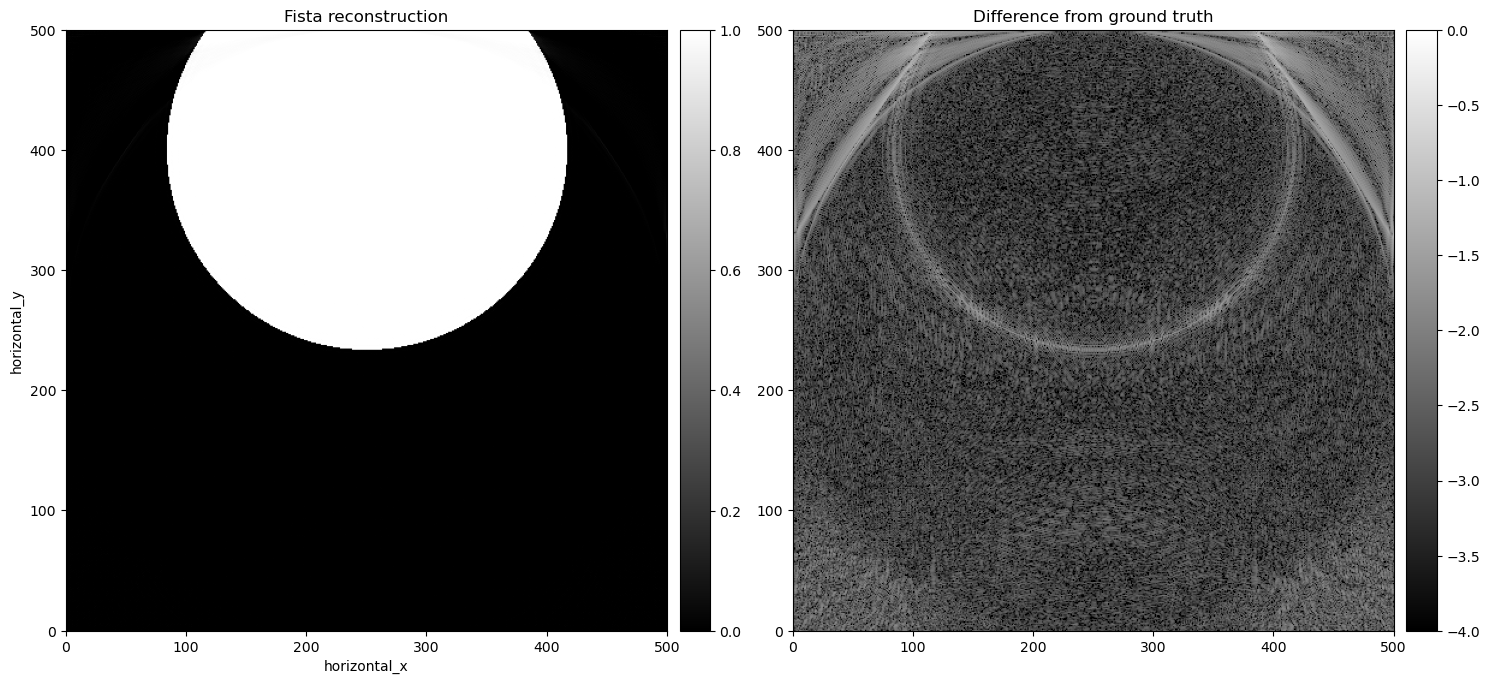

In [448]:
recon_err = myFISTANN.solution - image
plots = [myFISTANN.solution, np.log10(1e-10 + np.abs(recon_err.as_array()))]
titles = ["Fista reconstruction","Difference from ground truth" ]
#, fix_range=[(-0.2,1.2),(-0.2,0.2)]
show2D(plots, titles, fix_range=[(0,1),(-4,0)])